# Simon amacrine OMS search
VR Sept 2024

In [1]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import glob

import sys
sys.path.append('../dj_modules/')
import dj_metadata as djm
import dj_populate as djp

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
sys.path.append('../data_modules/')
import spikeoutputs as so
import spikeplots as sp

dj.config['database.host'] = '127.0.0.1'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'simple'
dj.conn()

[2024-09-23 14:31:11,449][INFO]: Connecting root@127.0.0.1:3306
[2024-09-23 14:31:11,656][INFO]: Connected root@127.0.0.1:3306


DataJoint connection (connected) root@127.0.0.1:3306

In [2]:
# This may take a few minutes if running for the first time.
str_metadata_dir = '/Volumes/data-1/data/metadata/json/'
djm.load_metadata(str_metadata_dir)
djp.load_chunks_and_files()
djp.load_typing()

Added 0 new experiments
20230825C not in Experiment table.
20230825C not in Experiment table.
20230825C not in Experiment table.
20240606H not in Experiment table.
20240611H not in Experiment table.
20240611H not in Experiment table.
20240627H not in Experiment table.
20240627H not in Experiment table.
20240717H not in Experiment table.
20240717H not in Experiment table.
20240717H not in Experiment table.
Added 0 new data files


In [3]:
ls_protocols = djm.search_protocol('objectmotion')
print(ls_protocols)

['manookinlab.protocols.ObjectMotionDots']


In [4]:
df_meta = djm.meta_from_protocol(ls_protocols)
df_meta

frame_times  \
date_id   protocol_id                            group_idx data_file block_idx chunk_id                                                      
20220531C manookinlab.protocols.ObjectMotionDots 0         data018   0         chunk2                                                   []   
                                                           data019   1         chunk2                                                   []   
                                                           data020   2         chunk2    [[1, 2, 20, 33, 53, 66, 86, 99, 119, 132, 152,...   
20220712C manookinlab.protocols.ObjectMotionDots 0         data037   0         chunk3    [[1, 1, 19, 32, 52, 65, 85, 98, 119, 131, 152,...   
20220816C manookinlab.protocols.ObjectMotionDots 0         data017   0         chunk2    [[1, 2, 20, 33, 53, 66, 86, 99, 119, 132, 152,...   
...                                                                                                                                    ...   
20240523C manookinlab.protocols.ObjectMotionDots 0         data004   0         chunk1    [[0.0, 13.0, 30.0, 46.0, 63.0, 80.0, 97.0, 113...   
                                                 2         data019   0         chunk2    [[0.0, 13.0, 30.0, 46.0, 63.0, 80.0, 97.0, 113...   
                                                 1         data028   0         motion    [[0.0, 13.0, 30.0, 46.0, 63.0, 80.0, 97.0, 113...   
20240717C manookinlab.protocols.ObjectMotionDots 0         data010   0         chunk2    [[0.0, 16.0, 31.0, 48.0, 64.0, 81.0, 98.0, 114...   
20240813C manookinlab.protocols.ObjectMotionDots 0         data005   0         chunk2    [[0.0, 16.0, 30.0, 47.0, 63.0, 80.0, 97.0, 113...   

                                                                                         n_epochs  
date_id   protocol_id                            group_idx data_file block_idx chunk_id            
20220531C manookinlab.protocols.ObjectMotionDots 0         data018   0         chunk2           8  
                                                           data019   1         chunk2          16  
                                                           data020   2         chunk2          16  
20220712C manookinlab.protocols.ObjectMotionDots 0         data037   0         chunk3          64  
20220816C manookinlab.protocols.ObjectMotionDots 0         data017   0         chunk2          48  
...                                                                                           ...  
20240523C manookinlab.protocols.ObjectMotionDots 0         data004   0         chunk1          16  
                                                 2         data019   0         chunk2          16  
                                                 1         data028   0         motion          16  
20240717C manookinlab.protocols.ObjectMotionDots 0         data010   0         chunk2          13  
20240813C manookinlab.protocols.ObjectMotionDots 0         data005   0         chunk2          13  

[96 rows x 2 columns]

In [5]:
df_ct = djm.celltyping_from_meta(df_meta).reset_index()
df_ct.head()

,date_id,protocol_id,group_idx,noise_data_file,block_idx,chunk_id,noise_data_files,algorithm,b_typing_file_exists,typing_file,num_cells,num_goodcells,num_on_p,num_off_p,num_on_m,num_off_m,num_sbc
0,20220712C,manookinlab.protocols.FastNoise,0,data021,3,chunk3,data021_data022,kilosort2,1,/Volumes/data-1/analysis/20220712C/chunk3/kilo...,697,697,84,86,0,138,0
1,20220909C,manookinlab.protocols.FastNoise,0,data001,0,chunk1,data001,kilosort2,1,/Volumes/data-1/analysis/20220909C/chunk1/kilo...,513,513,47,35,136,116,0
2,20221006C,manookinlab.protocols.FastNoise,0,data033,3,chunk3,data033,yass,1,/Volumes/data-1/analysis/20221006C/chunk3/yass...,1352,1352,19,92,1,159,0
3,20230105C,manookinlab.protocols.FastNoise,0,data028,4,chunk4,data028_data039,kilosort2,1,/Volumes/data-1/analysis/20230105C/chunk4/kilo...,840,840,69,85,53,160,10
4,20230105C,manookinlab.protocols.FastNoise,0,data028,4,chunk4,data028_data039,kilosort2,1,/Volumes/data-1/analysis/20230105C/chunk4/kilo...,840,840,69,85,53,160,10


We can populate a num_amacrines column.

In [6]:
import celltype_io as ctio
import importlib
importlib.reload(ctio)

# Add columns
df_ct['num_amacrine'] = 0
df_ct['amacrine_types'] = None

for r_idx in range(df_ct.shape[0]):
# r_idx = 0
    str_typing = df_ct.loc[r_idx, 'typing_file']
    c_types = ctio.CellTypes(str_typing)
    ls_amacrines = []
    for n_ID in c_types.d_types.keys():
        str_type = c_types.d_types[n_ID]
        if 'amacrine' in str_type.lower():
            ls_amacrines.append(str_type)
    if len(ls_amacrines) > 0:
        df_ct.loc[r_idx, 'num_amacrine'] = len(ls_amacrines)
        df_ct.at[r_idx, 'amacrine_types'] = list(np.unique(ls_amacrines))

Error: 2 space delimiter resulted in (558,) shape


<Axes: xlabel='num_amacrine', ylabel='num_off_p'>

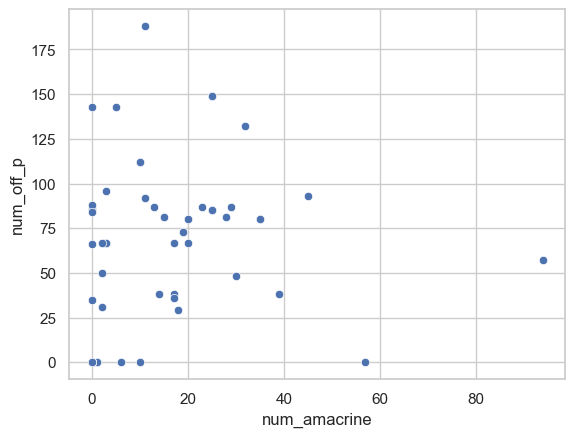

In [7]:
sns.scatterplot(data=df_ct, x='num_amacrine', y='num_off_p')

## Pull OMS data

We can now query datasets with >= x amacrines (and >= y parasols if we wanted), load in their OMS dots responses, and compute a slope value as a first pass analysis variable.

In [8]:
df_meta = df_meta.reset_index()
df_meta.head()

,date_id,protocol_id,group_idx,data_file,block_idx,chunk_id,frame_times,n_epochs
0,20220531C,manookinlab.protocols.ObjectMotionDots,0,data018,0,chunk2,[],8
1,20220531C,manookinlab.protocols.ObjectMotionDots,0,data019,1,chunk2,[],16
2,20220531C,manookinlab.protocols.ObjectMotionDots,0,data020,2,chunk2,"[[1, 2, 20, 33, 53, 66, 86, 99, 119, 132, 152,...",16
3,20220712C,manookinlab.protocols.ObjectMotionDots,0,data037,0,chunk3,"[[1, 1, 19, 32, 52, 65, 85, 98, 119, 131, 152,...",64
4,20220816C,manookinlab.protocols.ObjectMotionDots,0,data017,0,chunk2,"[[1, 2, 20, 33, 53, 66, 86, 99, 119, 132, 152,...",48


In [34]:
def get_oms_fr(data, ls_ids):
    # Compute mean firing rate for each spaceConstant condition.
    # Returns dataframe with columns ['date_id', 'chunk_id', 'algorithm', 'cell_id', 
    #                                 'space_constant', 'mean_fr', 'std_fr']
    ls_data = []

    epoch_space_constants = data.stim['params']['spaceConstant']
    unique_space_constants = data.stim['unique_params']['spaceConstants']

    time_idx = np.arange(data.stim['n_pre_pts'], data.stim['n_pre_pts'] + data.stim['n_stim_pts']+1)
    response_ids = np.array(list(data.spikes['spike_dict'].keys()))
    ls_ids = np.intersect1d(ls_ids, response_ids)
    for cell_id in ls_ids:
        d_insert = {'date_id': data.str_experiment, 'chunk_id': data.str_chunk, 
                    'algorithm': data.str_algo, 'cell_id': cell_id}
        for idx_sp, sp in enumerate(unique_space_constants):
            epoch_idx = np.where(epoch_space_constants == sp)[0]
            psth = data.spikes['spike_dict'][cell_id][epoch_idx, :]
            psth = psth[:, time_idx]
            mean_fr = psth.mean()
            std_fr = psth.std()
            d_insert['space_constant'] = sp
            d_insert['mean_fr'] = mean_fr
            d_insert['std_fr'] = std_fr
            ls_data.append(d_insert.copy())
    df_mean_fr = pd.DataFrame(ls_data)
    return df_mean_fr

In [117]:
# For every date-chunk-algo combination in df_ct, if multiple typing files, keep only the one with maximum amacrines
df_ct_filt = df_ct.copy()
for str_date in df_ct_filt['date_id'].unique():
    df_d = df_ct_filt[df_ct_filt['date_id'] == str_date]
    for str_chunk in df_d['chunk_id'].unique():
        df_dc = df_d[df_d['chunk_id'] == str_chunk]
        for str_algo in df_dc['algorithm'].unique():
            df_dca = df_dc[df_dc['algorithm'] == str_algo]
            if df_dca.shape[0] > 1:
                idx_max = df_dca['num_amacrine'].idxmax()
                # Drop all rows except the one with maximum amacrines
                df_ct_filt = df_ct_filt.drop(df_dca.index.difference([idx_max]))

In [118]:
import tqdm
n_min_amacrines = 5
bin_rate = 100.0

# We'll collect results in a list of dataframes that we'll concatenate at the end.
ls_dfs = [] 

# Get rows with at least n_min_amacrines
good_rows = df_ct_filt[df_ct_filt['num_amacrine'] >= n_min_amacrines].index

for r_idx in tqdm.tqdm(good_rows):
    # Paths for SpikeOutputs object
    d_paths = {'str_experiment': df_ct_filt.loc[r_idx, 'date_id'],
            'dataset_name': df_ct_filt.loc[r_idx, 'algorithm'],
            'str_algo': df_ct_filt.loc[r_idx, 'algorithm'],
            'str_chunk': df_ct_filt.loc[r_idx, 'chunk_id'],
            'ls_noise_filenames': df_ct_filt.loc[r_idx, 'noise_data_files'].split('_'),
            'str_classification': df_ct_filt.loc[r_idx, 'typing_file']}
    
    # Get data file names for OMS dots from df_meta
    df_oms = df_meta[(df_meta['date_id'] == d_paths['str_experiment']) & (df_meta['chunk_id'] == d_paths['str_chunk'])]
    d_paths['ls_filenames'] = df_oms['data_file'].values
    
    # Load data and compute firing rates. 
    try:
        data = so.SpikeOutputs(**d_paths, ls_RGC_labels=['amacrine'])
        ls_param_names = ['preTime', 'tailTime', 'waitTime', 'moveTime', 'spaceConstant', 'spaceConstants', 'radius', 
                'radiusPix', 'dotDensity', 'numDots',
                'contrast', 'splitContrasts', 'motionStd', 'backgroundIntensity']
        
        data.load_psth('objectmotion', ls_param_names, bin_rate, b_load_isi=False)
        ls_ids = data.types.d_main_IDs['amacrine']
        df_fr = get_oms_fr(data, ls_ids)
        ls_dfs.append(df_fr)
    
    # In case of any error w/ loading
    except Exception as e:
        print(e)
        print('Error with', d_paths)
        continue

  0%|          | 0/24 [00:00<?, ?it/s]

Processing group 1 of 1 and block 1 of 1


  4%|▍         | 1/24 [00:07<02:51,  7.44s/it]

Processing group 1 of 1 and block 1 of 1


  8%|▊         | 2/24 [00:12<02:13,  6.08s/it]

Processing group 1 of 1 and block 1 of 1


 12%|█▎        | 3/24 [00:18<02:02,  5.84s/it]

Processing group 1 of 1 and block 1 of 1


 17%|█▋        | 4/24 [00:26<02:16,  6.84s/it]

Processing group 1 of 1 and block 1 of 1


 21%|██        | 5/24 [00:31<02:00,  6.32s/it]

Processing group 1 of 1 and block 1 of 1


 25%|██▌       | 6/24 [00:35<01:37,  5.44s/it]

Processing group 1 of 1 and block 1 of 1


 29%|██▉       | 7/24 [00:40<01:27,  5.12s/it]

Processing group 1 of 1 and block 1 of 3
Processing group 1 of 1 and block 2 of 3
Processing group 1 of 1 and block 3 of 3


 33%|███▎      | 8/24 [00:49<01:41,  6.37s/it]

Processing group 1 of 1 and block 1 of 1


 42%|████▏     | 10/24 [00:53<00:55,  4.00s/it]

Processing group 1 of 1 and block 1 of 2
Could not find data file: /Volumes/data-1/data/sorted/20230418C/data016/kilosort2
Error with {'str_experiment': '20230418C', 'dataset_name': 'kilosort2', 'str_algo': 'kilosort2', 'str_chunk': 'chunk3', 'ls_noise_filenames': ['data011', 'data012'], 'str_classification': '/Volumes/data-1/analysis/20230418C/chunk3/kilosort2/kilosort2.classification.txt', 'ls_filenames': array(['data016', 'data017'], dtype=object)}
Processing group 1 of 1 and block 1 of 2
Processing group 1 of 1 and block 2 of 2


 46%|████▌     | 11/24 [00:58<00:56,  4.32s/it]

Processing group 1 of 1 and block 1 of 2
Processing group 1 of 1 and block 2 of 2


 50%|█████     | 12/24 [01:04<00:58,  4.88s/it]

Processing group 1 of 1 and block 1 of 2
Processing group 1 of 1 and block 2 of 2


 54%|█████▍    | 13/24 [01:10<00:57,  5.20s/it]

Processing group 1 of 1 and block 1 of 2
Processing group 1 of 1 and block 2 of 2


 58%|█████▊    | 14/24 [01:16<00:54,  5.48s/it]

Processing group 1 of 1 and block 1 of 2
Processing group 1 of 1 and block 2 of 2


 62%|██████▎   | 15/24 [01:23<00:54,  6.01s/it]

Processing group 1 of 1 and block 1 of 1


 67%|██████▋   | 16/24 [01:26<00:39,  4.98s/it]

Processing group 1 of 2 and block 1 of 1
Processing group 2 of 2 and block 1 of 1


 71%|███████   | 17/24 [01:30<00:33,  4.84s/it]

Processing group 1 of 1 and block 1 of 2
Processing group 1 of 1 and block 2 of 2


 75%|███████▌  | 18/24 [01:37<00:32,  5.44s/it]

Processing group 1 of 1 and block 1 of 1


 79%|███████▉  | 19/24 [01:41<00:25,  5.04s/it]

Processing group 1 of 1 and block 1 of 1


 83%|████████▎ | 20/24 [01:45<00:19,  4.78s/it]

Processing group 1 of 1 and block 1 of 2
Processing group 1 of 1 and block 2 of 2


 88%|████████▊ | 21/24 [01:54<00:17,  5.81s/it]

Processing group 1 of 1 and block 1 of 1


 92%|█████████▏| 22/24 [01:58<00:10,  5.44s/it]

Processing group 1 of 1 and block 1 of 1


 96%|█████████▌| 23/24 [02:03<00:05,  5.21s/it]

Processing group 1 of 1 and block 1 of 1


100%|██████████| 24/24 [02:07<00:00,  5.32s/it]

'amacrine'
Error with {'str_experiment': '20240717C', 'dataset_name': 'kilosort2.5', 'str_algo': 'kilosort2.5', 'str_chunk': 'chunk2', 'ls_noise_filenames': ['data006'], 'str_classification': '/Volumes/data-1/analysis/20240717C/chunk2/kilosort2.5/vr_kilosort2.5.classification.txt', 'ls_filenames': array(['data010'], dtype=object)}


## Analysis

In [119]:
df_oms_fr = pd.concat(ls_dfs)
df_oms_fr.head()

,date_id,chunk_id,algorithm,cell_id,space_constant,mean_fr,std_fr
0,20221006C,chunk3,yass,224,50.0,61.144596,61.455445
1,20221006C,chunk3,yass,224,100.0,44.371004,49.099752
2,20221006C,chunk3,yass,224,200.0,30.119891,40.909838
3,20221006C,chunk3,yass,224,300.0,24.989604,35.934919
4,20221006C,chunk3,yass,224,400.0,24.677054,35.861010


Let's compute OMS curve slopes for each cell

In [121]:
d_oms_slopes = {'date_id': [], 'chunk_id': [], 'algorithm': [], 'cell_id': [], 
                'slope': []}
for str_date in df_oms_fr['date_id'].unique():
    df_d = df_oms_fr[df_oms_fr['date_id'] == str_date]
    for str_chunk in df_d['chunk_id'].unique():
        df_dc = df_d[df_d['chunk_id'] == str_chunk]
        for str_algo in df_dc['algorithm'].unique():
            df_dca = df_dc[df_dc['algorithm'] == str_algo]
            for cell_id in df_dca['cell_id'].unique():
                df_dcac = df_dca[df_dca['cell_id'] == cell_id]
                
                min_sp = df_dcac['space_constant'].min()
                max_sp = df_dcac['space_constant'].max()
                min_sp_idx = df_dcac[df_dcac['space_constant'] == min_sp].index[0]
                max_sp_idx = df_dcac[df_dcac['space_constant'] == max_sp].index[0]
                min_sp_fr = df_dcac.at[min_sp_idx, 'mean_fr']
                max_sp_fr = df_dcac.at[max_sp_idx, 'mean_fr']
                slope = (max_sp_fr - min_sp_fr) / (max_sp - min_sp)
                
                d_oms_slopes['date_id'].append(str_date)
                d_oms_slopes['chunk_id'].append(str_chunk)
                d_oms_slopes['algorithm'].append(str_algo)
                d_oms_slopes['cell_id'].append(cell_id)
                d_oms_slopes['slope'].append(slope)
df_oms_slopes = pd.DataFrame(d_oms_slopes)

In [149]:
# Let's add a dataset variable that is date_id + chunk_id + algorithm
df_oms_slopes['dataset'] = df_oms_slopes['date_id'] + '_' + df_oms_slopes['chunk_id'] + '_' + df_oms_slopes['algorithm']
df_oms_fr['dataset'] = df_oms_fr['date_id'] + '_' + df_oms_fr['chunk_id'] + '_' + df_oms_fr['algorithm']

Distribution of OMS slopes for each amacrine cell

<Axes: xlabel='slope', ylabel='dataset'>

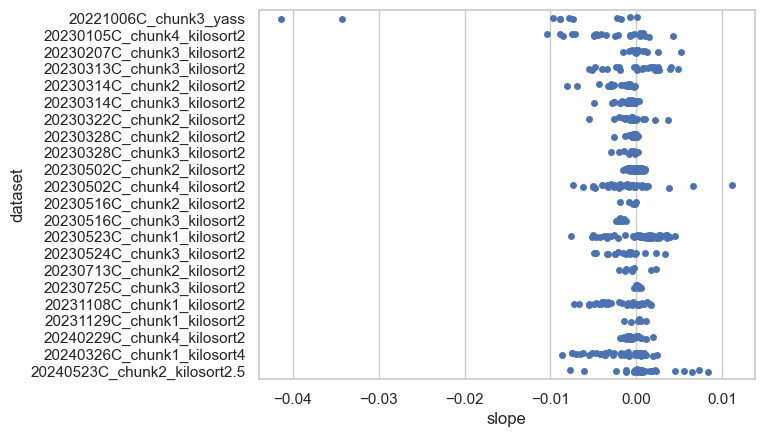

In [151]:
sns.stripplot(y='dataset', x='slope', data=df_oms_slopes)

Top Amacrines with positive slope

Text(0.5, 1.0, 'Top 10 Amacrines with a positive slope')

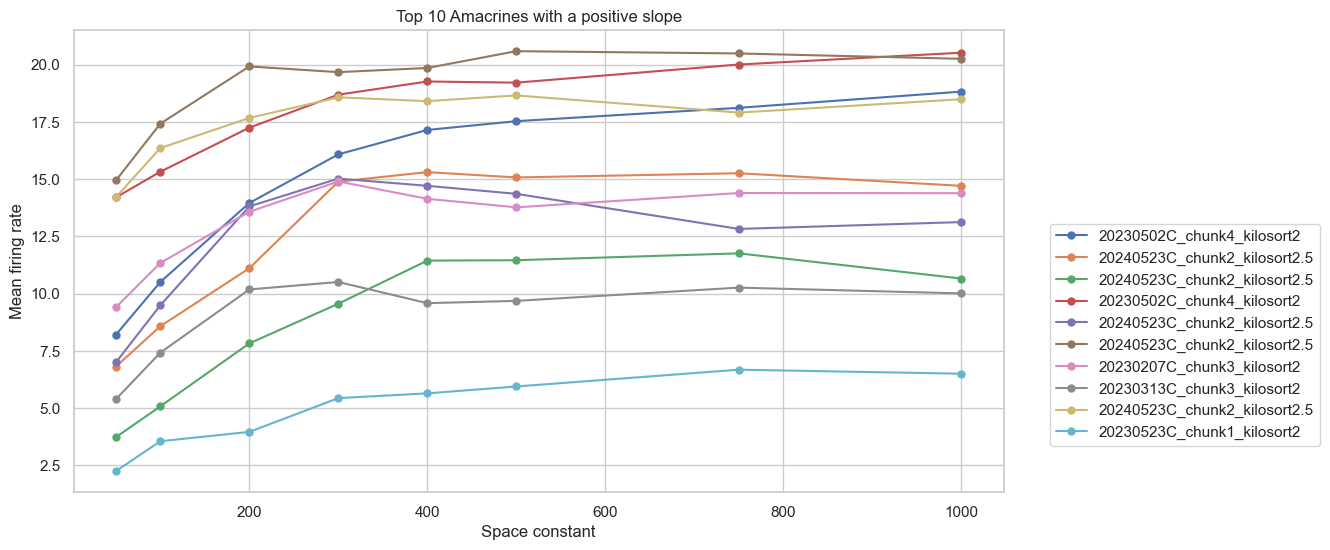

In [163]:
n_top = 10
top_rows = df_oms_slopes['slope'].nlargest(n_top).index

f, ax = plt.subplots(1, 1, figsize=(12, 6))
for r_idx in top_rows:
    str_date = df_oms_slopes.loc[r_idx, 'date_id']
    str_chunk = df_oms_slopes.loc[r_idx, 'chunk_id']
    str_algo = df_oms_slopes.loc[r_idx, 'algorithm']
    str_cell = df_oms_slopes.loc[r_idx, 'cell_id']
    df_cell = df_oms_fr[(df_oms_fr['date_id'] == str_date) & (df_oms_fr['chunk_id'] == str_chunk) & 
                        (df_oms_fr['algorithm'] == str_algo) & (df_oms_fr['cell_id'] == str_cell)]
    ax.plot(df_cell['space_constant'], df_cell['mean_fr'], label=df_cell['dataset'].values[0],
            marker='o', markersize=5)
ax.set_xlabel('Space constant')
ax.set_ylabel('Mean firing rate')
ax.legend(loc=(1.05, 0.1))
ax.set_title(f'Top {n_top} Amacrines with a positive slope')